## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/15yr_stochastic_analysis/blob/master/tutorials/model_selection.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [57]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions la_forge h5pulsar ipympl
!git clone https://github.com/AaronDJohnson/15yr_stochastic_analysis
import sys
sys.path.insert(0,'/content/15yr_stochastic_analysis/tutorials')

# Using `enterprise` to perform model selection

In this notebook you will learn:
* How to use `enterprise_extensions` to create models with NANOGrav data,
* How to perform model selection on the NANOGrav 15-year data set using `HyperModel`.
* How to reproduce some of Figure 2 of the NANOGrav 15-year GWB paper

# Load packages and modules

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import json, sys, glob
import matplotlib.pyplot as plt
import numpy as np

from enterprise_extensions import models, model_utils, hypermodel

from h5pulsar.pulsar import FilePulsar

from la_forge import core, slices, bfacs

from extra_functions import ti_log_evidence

IN_COLAB = 'google.colab' in sys.modules

Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [3]:
if IN_COLAB:
    datadir = '/content/15yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

## Load the full set of Pulsar objects

  * These files have been stored as `HDF5` files to make them much faster to load (and take up little space)
  
  * See the `explore_data.ipynb` tutorial to see what exists in these files and how to load `.par` and `.tim` files

In [4]:
psrs = []
for hdf5_file in glob.glob(datadir + '/hdf5/*.hdf5'):
    psrs.append(FilePulsar(hdf5_file))
print('Loaded {0} pulsars from hdf5 files'.format(len(psrs)))

Loaded 67 pulsars from hdf5 files


## Read in white noise dictionaries
  * We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 

  * In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches to reduce the computational cost of the analysis significantly through reduction in the number of parameters.

  * The noise properties have been stored as `json` files, and are read into a big parameter dictionary.

In [5]:
## Get parameter noise dictionary
noise_ng15 = datadir + '/15yr_wn_dict.json'

wn_params = {}
with open(noise_ng15, 'r') as fp:
    wn_params.update(json.load(fp))

# Model Selection: `Common uncorrelated red noise (CURN)` vs. `Hellings and Downs (HD) correlations`

* This notebook reproduces one of the Bayes factors found in figure 2 of the 15-year GWB analysis paper. Bayes factors tell us which model is preferred by the data between two models.

* The process of comparing between different models is known as model selection. Here, we choose between a `CURN` with a common (but uncorrelated) red noise process in the pulsars, and `HD` with a common, HD correlated red process among all pulsars

* To test between models we use a form of product-space sampling which in NANOGrav is called the `HyperModel` framework. This concatenates two models and samples the unique parameters among both the models with a switch that chooses between them, called `nmodel`. Which model is sampled at any step depends on the posterior values found at each proposed point.

In [6]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_general(psrs, noisedict=wn_params, common_components=14, tm_svd=True,
                              orf='crn', common_psd='powerlaw', tm_marg=True)
pta[1] = models.model_general(psrs, noisedict=wn_params, common_components=14, tm_svd=True,
                              orf='hd', common_psd='powerlaw', tm_marg=True)

* In setting up the `HyperModel` in the next cell, we set weights to make the models sample more evenly.

* `log_weights` is a Python `list` with the same length as the number of models, and each entry is added to the corresponding log-likelihood at each sampling step, thereby increasing the probability with which that model will be selected.

* We will undo the `log_weights` later in post-processing the chains

In [7]:
super_model = hypermodel.HyperModel(pta, log_weights=[np.log(300), 0])

In [8]:
if IN_COLAB:
    outDir = '/content/15yr_stochastic_analysis/tutorials/chains/ms_curn_hd_chains'
else:
    outDir = './chains/ms_curn_hd_chains'
sampler = super_model.setup_sampler(resume=True, outdir=outDir, sample_nmodel=True,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



In [9]:
# sampler for N steps
N = int(5e6)  # 5e6 is a good number for a real analysis
x0 = super_model.initial_sample()

* While you can sample this yourself, it will take several hours to get enough samples. Samples have been packaged in this tutorial so that we can move on and discuss post-processing.

In [10]:
# sample
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [11]:
# set the location to load presampled chains from
if IN_COLAB:
    presampled = '/content/15yr_stochastic_analysis/tutorials/presampled_cores'
else:
    presampled = './presampled_cores'

In [12]:
c1 = core.Core(corepath=presampled + '/curn_hd.core')

### `HyperModel` for model selection
* `CURN` when `nmodel` < 0.5
* `HD` when `nmodel` > 0.5
* weight of a factor of 300 in favor of the `CURN` model

Text(0, 0.5, 'pdf')

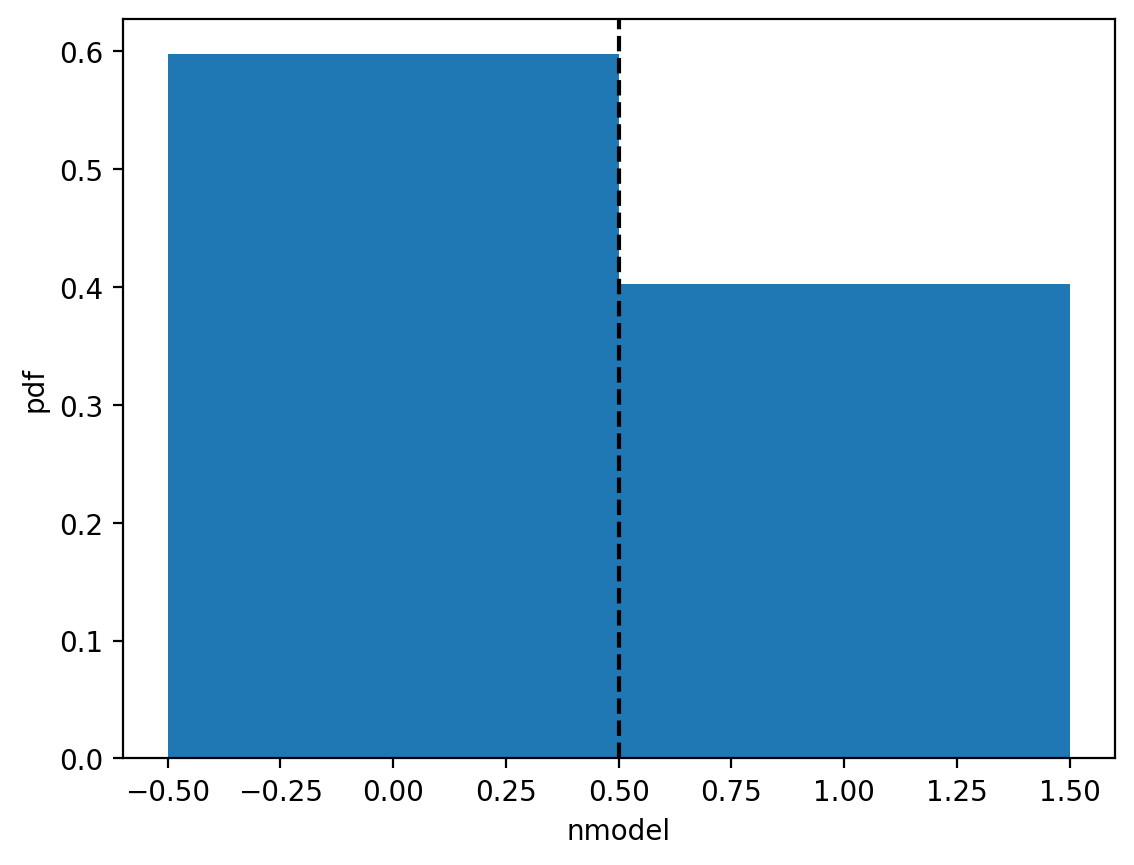

In [13]:
res = plt.hist(c1.get_param('nmodel'), bins=2, density=True)
plt.axvline(0.5, color='k', ls='--')
plt.xlabel('nmodel')
plt.ylabel('pdf')

* From this histogram, it is clear that with a heavy weight on the `CURN` model, the first model is preferred.

* We will now undo this weight by multiplying the Bayes factor by the weight. It's important to undo the logarithm when before we multiply (above the log-weight was $\log(300)$)

In [14]:
curn_samples = len(c1.get_param('nmodel')[c1.get_param('nmodel') < 0.5])
hd_samples = len(c1.get_param('nmodel')[c1.get_param('nmodel') > 0.5])

In [15]:
# This is the Bayes factor
hd_samples / curn_samples * 300

202.2219740955784

* Now that we have a Bayes factor, we need to estimate the uncertainty on it.

* For this we use a standard bootstrap method which samples the entire chain with replacement some number of realizations.

In [16]:
rng = np.random.default_rng()  # set up a random number generator

# define a bootstrap function for the core object
def bootstrap(core, num_reals=10_000):
    array = core.get_param("nmodel")
    new_nmodels = rng.choice(array, (len(array), num_reals))
    return new_nmodels

In [17]:
num_reals = 10_000
new_nmodels = bootstrap(c1)

ors = np.zeros(num_reals)
for ii in range(num_reals):
    ors[ii] = (len(np.where((new_nmodels[:, ii] > 0.5) & (new_nmodels[:, ii] <= 1.5))[0]) /
               len(np.where((new_nmodels[:, ii] > -0.5) & (new_nmodels[:, ii] <= 0.5))[0])) * 300
np.mean(ors), np.std(ors)

(202.2138635114302, 3.3998655668003295)

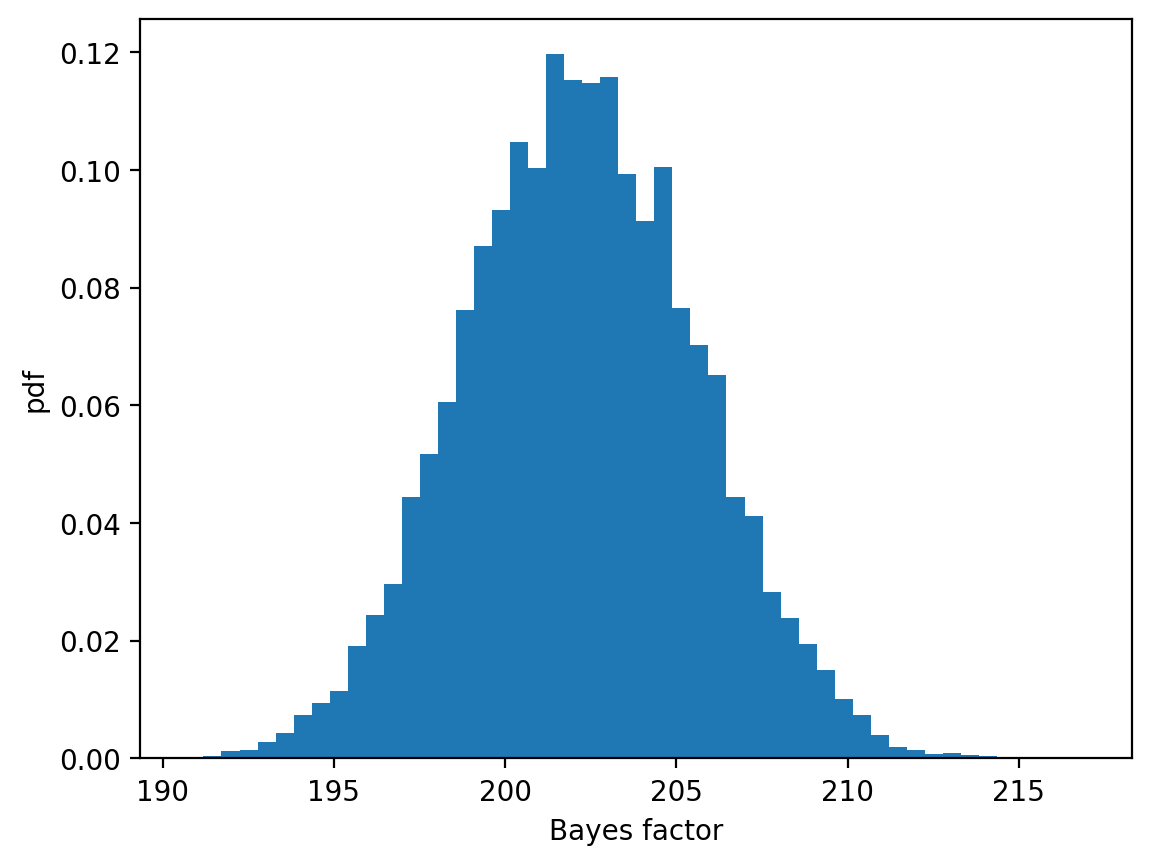

In [18]:
plt.hist(ors, bins=50, density=True);
plt.xlabel('Bayes factor');
plt.ylabel('pdf');

* Now, we have a Gaussian distribution on the Bayes factor of `HD` against `CURN` with `HD` favored with a Bayes factor of $202$ +/- $3.4$

## Thermodynamic Integration
* Another method to get a Bayes factor (but more expensive than the above) is known as thermodynamic integration.

* Here we show how to perform thermodynamic integration with `enterprise_extensions`, `PTMCMCSampler` and `la_forge`
* The sampling cannot be easily performed in a `Jupyter Notebook`, so we include a file named `ti_sample.py` to show how to do the sampling.
* Warning: This procedure is very expensive and will require a lot of memory
* Chains have been included here so that you do not have to do the sampling yourself

* These cores only contain the likelihood parameter from each of the chains for 31 temperatures
* The likelihood is raised to a power of $1/T$ for each chain and swaps were proposed between them using a process known as parallel tempering.
* The "power posterior" that we sample from is: $p(\vec{\eta} \mid \delta \vec{t}) \propto \mathcal{L}( \delta \vec{t} \mid \vec{\eta})^{1/T} \pi(\vec{\eta})$ instead of the usual $p(\vec{\eta} \mid \delta \vec{t}) \propto \mathcal{L}( \delta \vec{t} \mid \vec{\eta}) \pi(\vec{\eta})$
* Notice that when we sample with $T=1$ we are sampling the posterior, and when we sample with $T=\infty$, we are sampling from the prior
* Using this, we can compute the evidence for each model by seeing how the average log likelihood changes at each temperature, integrating from the prior to the posterior for each model.
* The log Bayes factor is then the difference between the log evidences obtained from thermodynamic integration.

### `IRN` against `CURN`

* First, we look at a model with only intrinsic red noise against one with a common uncorrelated red noise process

In [19]:
# load core objects containing the likelihoods from all the thermodynamic integration chains
irn_ti = slices.SlicesCore(corepath=presampled + '/irn_ti.core')
curn_ti = slices.SlicesCore(corepath=presampled + '/curn_ti.core')

In [20]:
# compute log_evidence for CURN and HD models
lnZ_irn = ti_log_evidence(irn_ti)
lnZ_curn = ti_log_evidence(curn_ti)


model:
$ln(evidence) = 7972999.679095135
error in ln_Z = 0.14750233872062327


model:
$ln(evidence) = 7973027.5722847115
error in ln_Z = 0.12954878398570874



In [21]:
# Use evidences to compute a Bayes factor
# scale can return this number as a log or unit scale value
bfacs.log10_bf(lnZ_irn, lnZ_curn, scale='log10')

/Users/aaron/mambaforge/envs/rosettaprise/lib/python3.10/site-packages/la_forge/bfacs.py:64: UserWarning: Obsolete: either use ufloat(nominal_value, std_dev), ufloat(nominal_value, std_dev, tag), or the ufloat_fromstr() function, for string representations. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  log_evidence1 = ufloat(log_ev1)
/Users/aaron/mambaforge/envs/rosettaprise/lib/python3.10/site-packages/la_forge/bfacs.py:65: UserWarning: Obsolete: either use ufloat(nominal_value, std_dev), ufloat(nominal_value, std_dev, tag), or the ufloat_fromstr() function, for string representations. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  log_evidence2 = ufloat(log_ev2)


(12.113858315735474, 0.08525879568084149)

* This value corresponds to a Bayes factor of $10^{12.11 \pm 0.087}$ in favor of `CURN` over `IRN`!

* Such a large Bayes factor is extremely difficult to compute with HyperModel sampling

* While this method is more expensive to compute, it requires no weights to check both models

In [22]:
# load core objects containing the likelihoods from all the thermodynamic integration chains
curn_ti = slices.SlicesCore(corepath=presampled + '/curn_ti.core')
hd_ti = slices.SlicesCore(corepath=presampled + '/hd_ti.core')

In [23]:
# compute log_evidence for CURN and HD models
lnZ_curn = ti_log_evidence(curn_ti)
lnZ_hd = ti_log_evidence(hd_ti)


model:
$ln(evidence) = 7973027.565956212
error in ln_Z = 0.1337580207156943


model:
$ln(evidence) = 7973032.8543338645
error in ln_Z = 0.1846912313796552



In [24]:
# Use evidences to compute a Bayes factor
# scale can return this number as a log or unit scale value
bfacs.log10_bf(lnZ_curn, lnZ_hd, scale='1')

(198.0219044034798, 45.156835821977516)

### Plot the average log likelihood over inverse temperature

* Here we see the spacing of the inverse temperatures on a log scale
* An infinite temperature is also included which corresponds to sampling the prior
* The maximum temperature picked to sample should be approximately horizontal with the infinite temperature

* We can be sure that we have a large enough range of temperatures to compute the evidence integral

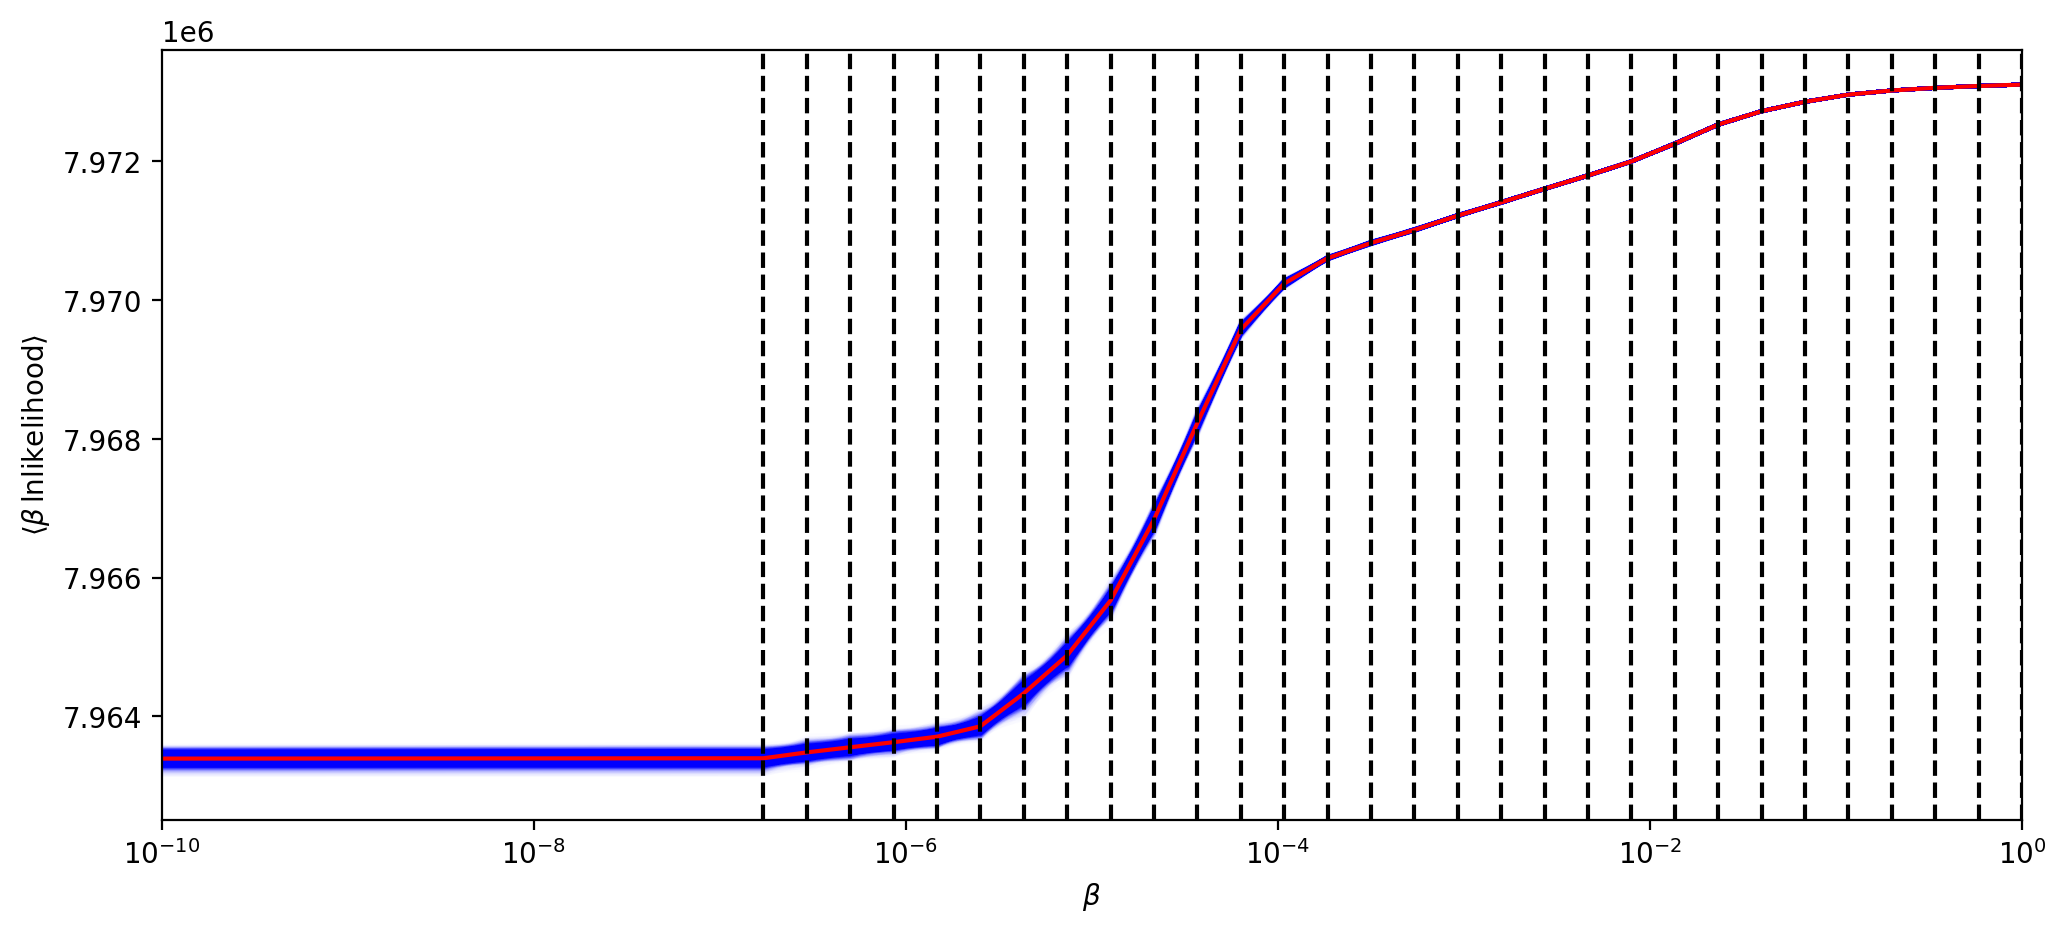


model:
$ln(evidence) = 7973027.568423509
error in ln_Z = 0.12840921166166502



<Figure size 640x480 with 0 Axes>

In [25]:
res = ti_log_evidence(curn_ti, plot=True);

* Here we have reproduced one part of Figure 2 in the 15-year GWB analysis

* We used the `HyperModel` framework and thermodynamic integration to compute Bayes factors between models: `IRN`, `CURN`, and `HD`